## Layer Normalization

### 1. 背景知识

在深层神经网络训练中，由于网络上层参数的变化而引起每层输入数据分布随之变化，这导致了训练过程变慢，这种现象叫做“Internal Covariate Shift”。

Batch Normalization 是解决该问题的有效方法，具体做法为：
* 对每个特征单独做 normalization。
* 在每个 mini-batch 上做 normalization。
* 同时，加上线性变换操作。

它的优点是可以加速训练，不需要很小心地初始化学习率等参数以及缓解过拟合。同时，也存在一些缺点：
* 当 batch size 比较小的时候，均值和方差没有很好的统计意义；
* 不适用于 RNN 等动态网络结构；
* 不适用于训练数据集和测试数据集方差比较大的时候。

Layer Normalization 可以解决上述问题。

### 2. Layer normalization

#### 2.1 MLP 中的 LN

LN 独立于 batch size，根据样本的特征数做归一化。先看 MLP 中的 LN，设 $H$ 是一层中隐藏节点的数量，$l$ 是 MLP 的层数，我们可以计算 LN 的归一化统计量 $\mu$ 和 $\sigma$：
$$\mu^l=\frac{1}{H}\sum^H_{i=1}a^l_{i},\ \ \ \sigma^l=\sqrt{\frac{1}{H}\sum^H_{i=1}(a^l_{i}-\mu^l)^2}$$
上面统计量的计算和样本数量没有关系，只取决于隐藏节点的数量，所以只要隐层节点的数量足够多，就能保证 LN 的归一化统计量具有代表性。通过 $\mu^l$ 和 $\sigma^l$ 可以得到归一化后的值 ${\hat{a}}^l$：
$$\hat{a}^l=\frac{a^l-\mu^l}{(\sigma^l)^2+\sqrt{\epsilon}}$$
其中，$\epsilon$ 是一个很小的数，防止除0。

为保证归一化操作不破坏之前的信息，LN 也使用一组参数 $g$（增益）和 $b$（偏置），等同于 BN 中的 $\gamma$ 和 $\beta$。假设激活函数为 $f$，则最终 LN 的输出为：
$$h^l=f(g^l \odot \hat{a}^l+b^l)$$
合并上式，并忽略参数 $l$，可以得到：
$$h=f(\frac{g}{\sqrt{\sigma^2+\epsilon}}\odot(a-\mu)+b)$$

#### 2.2 RNN 中的 LN

在 RNN 中，可以非常简单的在每个时间片中使用 LN，而且在任何时间片我们都能保证归一化统计量统计的是 H 个节点的信息。对于 RNN 的时刻 t 的节点，其输入是 t-1 时刻的隐层状态 $h^{t-1}$ 和 t 时刻的输入数据 $x^t$，可以表示为：
$$a^t=W_{hh}h^{t-1}+W_{xh}x^t$$
接着便可以在 $a^t$ 上采取和上面一致的归一化过程：
$$h^t=f(\frac{g}{\sqrt{(\sigma^t)^2+\epsilon}}\odot(a^t-\mu^t)+b),\ \ \mu^t=\frac{1}{H}\sum^H_{i=1}a^t_i,\ \ \sigma^t=\sqrt{\frac{1}{H}\sum^H_{i=1}(a^t_i-\mu^t)^2}$$

### 3. tensorflow 实现

In [ ]:
tf.contrib.layers.layer_norm(
    inputs,
    center=True,
    scale=True,
    activation_fn=None,
    reuse=None,
    variables_collections=None,
    outputs_collections=None,
    trainable=True,
    begin_norm_axis=1,
    begin_params_axis=-1,
    scope=None
)

一般只需要调 tf.contrib.layers.layer_norm(inputs) 就可以了。

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data/', one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


None: The final accuracy on validation data is 0.9702000021934509
bn: The final accuracy on validation data is 0.9742000102996826
ln: The final accuracy on validation data is 0.972000002861023


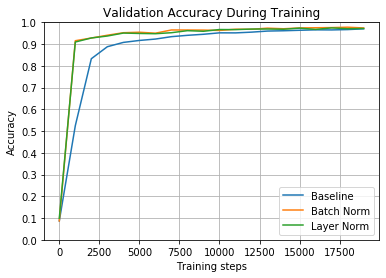

In [31]:
INPUT_NODE = 784
OUTPUT_NODE = 10

class NeuralNetwork():
    def __init__(self, norm_method, layer_num=3, hidden_size=128):
        self.is_training = tf.placeholder(tf.bool, name='training')
        self.norm_method = norm_method
        if norm_method == 'bn':
            self.name = 'Batch Norm'
        elif norm_method == 'ln':
            self.name = 'Layer Norm'
        else:
            self.name = 'Baseline'
        self.training_accuracies = []
        self.build_network(norm_method, layer_num, hidden_size)
        
    def build_network(self, norm_method, layer_num, hidden_size):
        self.x = tf.placeholder(tf.float32, [None, INPUT_NODE])
        layer_in = self.x
        
        for _ in range(layer_num):
            layer_in = self.fully_connect(layer_in, hidden_size, norm_method, tf.nn.sigmoid)
            
        self.output_layer = self.fully_connect(layer_in, OUTPUT_NODE, norm_method)
        
    def fully_connect(self, layer_in, out_size, norm_method, activation_fn=None):
        in_size = layer_in.shape[1].value
        weights = tf.Variable(tf.truncated_normal([in_size, out_size], stddev=0.1))
        bias = tf.Variable(tf.constant(0.1, shape=[out_size]))
        output = tf.add(tf.matmul(layer_in, weights), bias)
        if norm_method == 'bn' and activation_fn:
            batch_output = tf.layers.batch_normalization(output, training=self.is_training)
            return activation_fn(batch_output)
        elif norm_method == 'ln' and activation_fn:
            layer_output = tf.contrib.layers.layer_norm(output)
            return activation_fn(layer_output)
        else:
            return activation_fn(output) if activation_fn else output
        
    def train(self, sess, learning_rate=0.1, batch_size=60, training_batches=20000):
        labels = tf.placeholder(tf.float32, [None, 10])
        cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=labels,
                                                                  logits=self.output_layer))
        correct_prediction = tf.equal(tf.argmax(self.output_layer, 1), tf.argmax(labels, 1))
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
        
        if self.norm_method == 'bn':
            with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
                train_step = tf.train.GradientDescentOptimizer(learning_rate).minimize(cross_entropy)
        else:
            train_step = tf.train.GradientDescentOptimizer(learning_rate).minimize(cross_entropy)
            
        for i in range(training_batches):
            batch_x, batch_y = mnist.train.next_batch(batch_size)
            sess.run(train_step, feed_dict={self.x: batch_x, labels: batch_y,
                                           self.is_training: True})
            if i % 1000 == 0:
                val_accuracy = sess.run(accuracy, feed_dict={self.x: mnist.validation.images,
                                                            labels: mnist.validation.labels,
                                                            self.is_training: False})
                self.training_accuracies.append(val_accuracy)
        print('{}: The final accuracy on validation data is {}'.format(self.norm_method, val_accuracy))
            
def plot_training_accuracies(*args, batches_per_validate_data):
    fig, ax = plt.subplots()
    
    for nn in args:
        ax.plot(range(0, len(nn.training_accuracies)*batches_per_validate_data, batches_per_validate_data),
                nn.training_accuracies, label=nn.name)
    ax.set_xlabel('Training steps')
    ax.set_ylabel('Accuracy')
    ax.set_title('Validation Accuracy During Training')
    ax.legend(loc=4)
    ax.set_ylim([0,1])
    plt.yticks(np.arange(0, 1.1, 0.1))
    plt.grid(True)
    plt.show()
    
def train_and_test(batch_size):
    tf.reset_default_graph()
    nn = NeuralNetwork(None)
    bn = NeuralNetwork('bn')
    ln = NeuralNetwork('ln')
    with tf.Session() as sess:
        tf.global_variables_initializer().run()
        nn.train(sess, batch_size=batch_size)
        bn.train(sess, batch_size=batch_size)
        ln.train(sess, batch_size=batch_size)
    plot_training_accuracies(nn, bn, ln, batches_per_validate_data=1000)
    
train_and_test(60)

None: The final accuracy on validation data is 0.9545999765396118
bn: The final accuracy on validation data is 0.9571999907493591
ln: The final accuracy on validation data is 0.9728000164031982


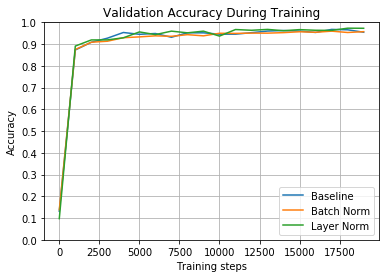

In [30]:
train_and_test(5)

可以看出，batch size 较大时，bn 比 ln 效果好，batch size 较小时，ln 效果较好。